# Power Plant Example

Example from "Approximate Inference for the loss-calibrated Bayesian" (Lacoste et el, 2011)

In [1]:
import numpy as np
import torch
from torch.distributions import Normal
import matplotlib.pyplot as plt

from typing import List, Tuple

Rebuild the example, assume a GMM for the posterior.

In [2]:
mu1, sigma1 = 30., 10.
mu2, sigma2 = 90., 15.

n1 = Normal(mu1, sigma1)
n2 = Normal(mu2, sigma2)

# mixture
px = lambda th: 0.7 * n1.log_prob(th).exp() + 0.3 * n2.log_prob(th).exp()

In [3]:
thetas = torch.linspace(-50,200,steps=10000)

In [23]:
samples = torch.cat([n1.sample((700,)), n2.sample((300,))], dim=0)

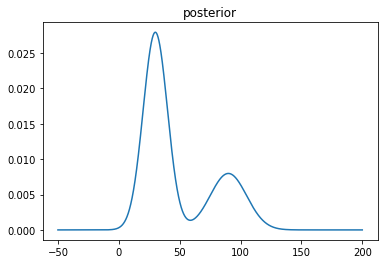

In [25]:
plt.plot(thetas, px(thetas).detach())
#plt.hist(samples.numpy(), bins=100, density=True)
plt.title('posterior')
plt.show()

### Define KL Divergence
Define forward and reverse KL separately to avoid unneccessary convertion between prob and log_prob, which seemed to cause numerical instabilities and led to inaccuracy during testing.

In [6]:
def kl(p,log_q):
    assert p.shape == log_q.shape
    return torch.sum(torch.where(p!=0, p * (p.log()-log_q), torch.zeros(1)))
    #return torch.sum(log_p.exp() * (log_p-log_q))

def reverse_kl(log_q,p):
    assert p.shape == log_q.shape
    return torch.sum(torch.where(torch.logical_not(log_q.isneginf()), log_q.exp() * (log_q - p.log()), torch.zeros(1)))
    #return torch.sum(log_p.exp() * (log_p-log_q))

Define the procedure to minimize the KL Divergence

In [7]:
# minimize forward KL
def minimize_kl(mu: float, sigma:float, epochs:int, kl_mode:str='forward') -> Tuple[float, float, List, List]:
    q_mu = torch.tensor([mu], requires_grad=True)    #torch.randint(0, 120, (1,)).float();q_mu.requires_grad=True
    q_sigma = torch.tensor([sigma], requires_grad=True)    #torch.randint(0, 60, (1,)).float();q_sigma.requires_grad=True

    opt = torch.optim.Adam([q_mu, q_sigma])

    q_logevals_all = []
    loss_vals = []


    for e in range(epochs):
        opt.zero_grad()
        q = Normal(q_mu, q_sigma)
        q_logevals = q.log_prob(thetas)
        if kl_mode=='reverse':
            loss = reverse_kl(q_logevals, px(thetas))
        else: 
            loss = kl(px(thetas), q_logevals)
        loss.backward()
        opt.step() 

        q_logevals_all.append(q_logevals[::3].detach().numpy()) # subsample every 3.sample
        loss_vals.append(loss.detach().numpy())
    
    return q_mu.item(), q_sigma.item(), q_logevals_all, loss_vals

To visualize the difference between forward and reverse KL, we are going to approximate the GMM with a single Gaussian.

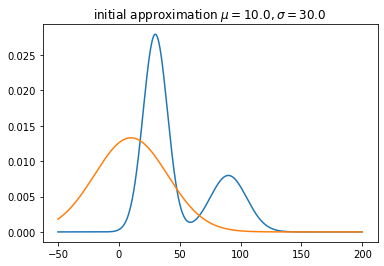

tensor(47.3600)

In [26]:
# approximation
q_mu = 10. #torch.randint(0, 120, (1,))
q_sigma = 30. #torch.randint(0, 60, (1,))
q = Normal(q_mu, q_sigma)

plt.plot(thetas, px(thetas))
plt.plot(thetas, q.log_prob(thetas).exp())
plt.title(f'initial approximation $\mu={q_mu}, \sigma={q_sigma}$')
plt.show()
kl(px(thetas), q.log_prob(thetas))

### Minimize forward KL

In [9]:
epochs = 50000
mu, sigma, q_logevals_all, loss_vals = minimize_kl(10., 30., epochs, 'forward')


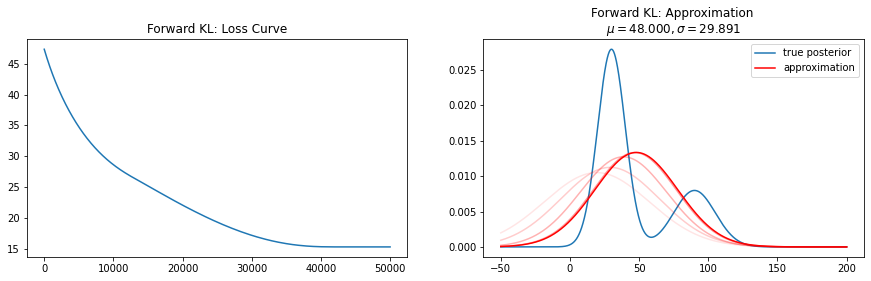

final loss: 15.273832321166992


In [34]:
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.plot(np.arange(epochs), loss_vals)
plt.title('Forward KL: Loss Curve')

plt.subplot(1,2,2)
plt.plot(thetas, px(thetas), label='true posterior')
for i in range(5):
    plt.plot(thetas[::3], np.exp(q_logevals_all[i*10000]), c='red', alpha=0.1*i)
plt.plot(thetas[::3], np.exp(q_logevals_all[-1]), c='red', label='approximation')
#plt.hist(samples.numpy(), bins=100, density=True)
plt.title(f'Forward KL: Approximation \n$\mu={mu:.3f}, \sigma={sigma:.3f}$')
plt.legend()
plt.show()
print(f'final loss: {loss_vals[-1]}')

### Minimize reverse KL

In [12]:
epochs = 50000
mu_rev, sigma_rev, q_logevals_all_rev, loss_vals_rev = minimize_kl(10., 30., epochs, 'reverse')

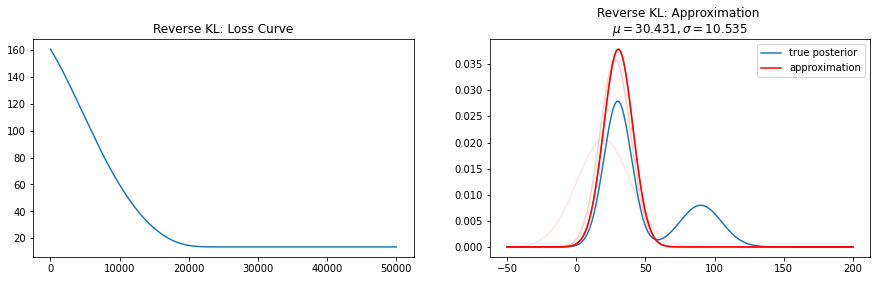

final loss: 13.726129531860352


In [36]:
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.plot(np.arange(epochs), loss_vals_rev)
plt.title('Reverse KL: Loss Curve')

plt.subplot(1,2,2)
plt.plot(thetas, px(thetas), label='true posterior')
for i in range(5):
    plt.plot(thetas[::3], np.exp(q_logevals_all_rev[i*10000]), c='red', alpha=0.1*i)
plt.plot(thetas[::3], np.exp(q_logevals_all_rev[-1]), c='red', label='approximation')
#plt.hist(samples.numpy(), bins=100, density=True)
plt.title(f'Reverse KL: Approximation \n$\mu={mu_rev:.3f}, \sigma={sigma_rev:.3f}$')
plt.legend()
plt.show()
print(f'final loss: {loss_vals_rev[-1]}')

Test forward/reverse KL implementations:

In [15]:
kl(px(thetas)[::3], q_logevals_all[-1])

tensor(5.0913)

In [16]:
kl(torch.tensor(q_logevals_all[-1]).exp(), px(thetas)[::3].log())

tensor(9.6981)

In [17]:
reverse_kl(torch.tensor(q_logevals_all[-1]),px(thetas)[::3])

tensor(9.6981)

In [18]:
reverse_kl(px(thetas)[::3].log(), torch.tensor(q_logevals_all[-1]).exp())

tensor(5.0913)